In [1]:
'''
This is where everything ends up from the creation notebook
'''

path_saves = './realistic', './unrealistic'


levels = ['low', 'medium', 'high']

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize global storage
global_storage = {
    'occ_lvl': [],
    'confidence': [],
    'accuracy_iou': [],
    'accuracy_label': [],
    'average_precision': []
}

# Validate occlusion levels
def validate_occlusion_level(occ_lvl):
    valid_levels = {"low", "medium", "high"}
    if occ_lvl.lower() not in valid_levels:
        raise ValueError(f"Invalid occlusion level '{occ_lvl}'. Expected one of {valid_levels}.")
    return occ_lvl.lower()

# Example function to add data
def store_metrics(occ_lvl, confidence, accuracy_iou, accuracy_label, average_precision):
    """
    Stores the provided metrics in global storage after validation.
    
    Parameters:
        occ_lvl (str): Occlusion level ('low', 'medium', 'high').
        confidence (float): Confidence value.
        accuracy_iou (float): Intersection over Union accuracy.
        accuracy_label (float): Label truth accuracy.
        average_precision (float): Average Precision metric.
    """
    validated_level = validate_occlusion_level(occ_lvl)
    global_storage['occ_lvl'].append(validated_level)
    global_storage['confidence'].append(confidence)
    global_storage['accuracy_iou'].append(accuracy_iou)
    global_storage['accuracy_label'].append(accuracy_label)
    global_storage['average_precision'].append(average_precision)

# Function to aggregate metrics by occlusion level
def aggregate_metrics():
    levels = ["low", "medium", "high"]
    aggregated = {level: {"confidence": [], "accuracy_iou": [], "accuracy_label": [], "average_precision": []} for level in levels}

    for occ_lvl, conf, iou, label, ap in zip(global_storage['occ_lvl'], global_storage['confidence'], global_storage['accuracy_iou'], global_storage['accuracy_label'], global_storage['average_precision']):
        aggregated[occ_lvl]["confidence"].append(conf)
        aggregated[occ_lvl]["accuracy_iou"].append(iou)
        aggregated[occ_lvl]["accuracy_label"].append(label)
        aggregated[occ_lvl]["average_precision"].append(ap)
    
    # Calculate averages
    averages = {
        level: {
            "confidence": np.mean(aggregated[level]["confidence"]) if aggregated[level]["confidence"] else 0,
            "accuracy_iou": np.mean(aggregated[level]["accuracy_iou"]) if aggregated[level]["accuracy_iou"] else 0,
            "accuracy_label": np.mean(aggregated[level]["accuracy_label"]) if aggregated[level]["accuracy_label"] else 0,
            "average_precision": np.mean(aggregated[level]["average_precision"]) if aggregated[level]["average_precision"] else 0
        }
        for level in levels
    }
    return averages

# Function to plot AP separately
def plot_average_precision(realisticness):
    averages = aggregate_metrics()
    levels = ["low", "medium", "high"]

    # Extract AP values for plotting
    average_precision = [averages[level]["average_precision"] for level in levels]

    plt.figure(figsize=(8, 6))
    plt.bar(levels, average_precision, color='skyblue', alpha=0.7)

    # Add labels, title, and grid
    plt.xlabel("Occlusion Levels")
    plt.ylabel("Average Precision (AP)")
    plt.title(f"Average Precision (AP) by Occlusion Levels for {realisticness} Dataset")
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Function to plot other metrics
def plot_metrics(realisticness):
    averages = aggregate_metrics()
    levels = ["low", "medium", "high"]

    # Extract metrics for plotting
    confidence = [averages[level]["confidence"] for level in levels]
    accuracy_iou = [averages[level]["accuracy_iou"] for level in levels]
    accuracy_label = [averages[level]["accuracy_label"] for level in levels]

    x = np.arange(len(levels))  # the label locations
    width = 0.25  # the width of the bars

    plt.figure(figsize=(10, 8))

    # Confidence Bar
    plt.bar(x - width, confidence, width, label='Confidence')
    # Accuracy IoU Bar
    plt.bar(x, accuracy_iou, width, label='Accuracy (IoU)')
    # Accuracy Label Bar
    plt.bar(x + width, accuracy_label, width, label='Accuracy (Label Truth)')

    # Add labels, title, and legend
    plt.xlabel("Occlusion Levels")
    plt.ylabel("Metrics")
    plt.title(f"Metrics by Occlusion Levels for {realisticness} Dataset")
    plt.xticks(x, levels)
    plt.legend()
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# # Example of adding metrics
# store_metrics(0.1, 0.85, 0.9, 0.88)
# store_metrics(0.2, 0.8, 0.85, 0.86)

# # Plot the graphs
# plot_metrics()


In [3]:
'''
Intersection Over Union
'''
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by the intersection area
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

In [4]:
import json

def read_annotation(anno_file):
    with open(anno_file, 'r') as f:
        # Load the JSON data into a Python dictionary

        anno = json.load(f)

        bg_bbox = anno['box']
        occlusion_ratio = anno['ratio']
        occluder_bbox = anno['occluder_box']
        occluder_path = anno['occluder_path']
        bg_img = anno['source']
        cate = anno['cate']

    return bg_bbox, occlusion_ratio, occluder_bbox, occluder_path, bg_img, cate

In [5]:
def process_one_img(processor, model, img_path):
    img = Image.open(img_path)
    
    inputs = processor(images=img, return_tensors="pt")
    outputs = model(**inputs)
    
    target_sizes = torch.tensor([img.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    return results

In [6]:
def get_updated_bb(bg_bbox, bg_w, bg_h, comp_w, comp_h):
    scale_w = comp_w / bg_w
    scale_h = comp_h / bg_h
    
    [x1, y1, x2, y2] = bg_bbox
    
    bb_w = x2 - x1
    bb_h = y2 - y1
    
    x1_new = int(x1 * scale_w)
    y1_new = int(y1 * scale_h)
    x2_new = int(x2 * scale_w)
    y2_new = int(y2 * scale_h)
    
    return [x1_new, y1_new, x2_new, y2_new]

------------------------
Occlusion level: low
------------------------
./realistic low small_n02834778_1446.jpg (0.9308221152584591, 'bicycle', 0.999) bicycle
./realistic low small_n02834778_11660.jpg (0.7576409703504043, 'bicycle', 0.995) bicycle
./realistic low medium_n02834778_12038.jpg (0.747914418241521, 'bicycle', 0.993) bicycle
./realistic low large_n02834778_12736.jpg (0.9378156812085271, 'bicycle', 0.992) bicycle
./realistic low large_n02834778_1372.jpg (0.9532030094570973, 'bicycle', 0.99) bicycle
./realistic low medium_n02834778_11341.jpg (0.8658025899928007, 'bicycle', 0.998) bicycle
NO VALID BOUNDING BOX
./realistic low large_n02834778_1863.jpg (0.7779846892210855, 'bicycle', 0.993) bicycle
./realistic low large_n02834778_10394.jpg (0.8057183912738197, 'bicycle', 0.961) bicycle
./realistic low small_n02834778_11865.jpg (0.7161981006376709, 'bicycle', 0.924) bicycle
NO VALID BOUNDING BOX
./realistic low small_n02834778_10753.jpg (0.8449746995572422, 'bicycle', 0.998) bicycl

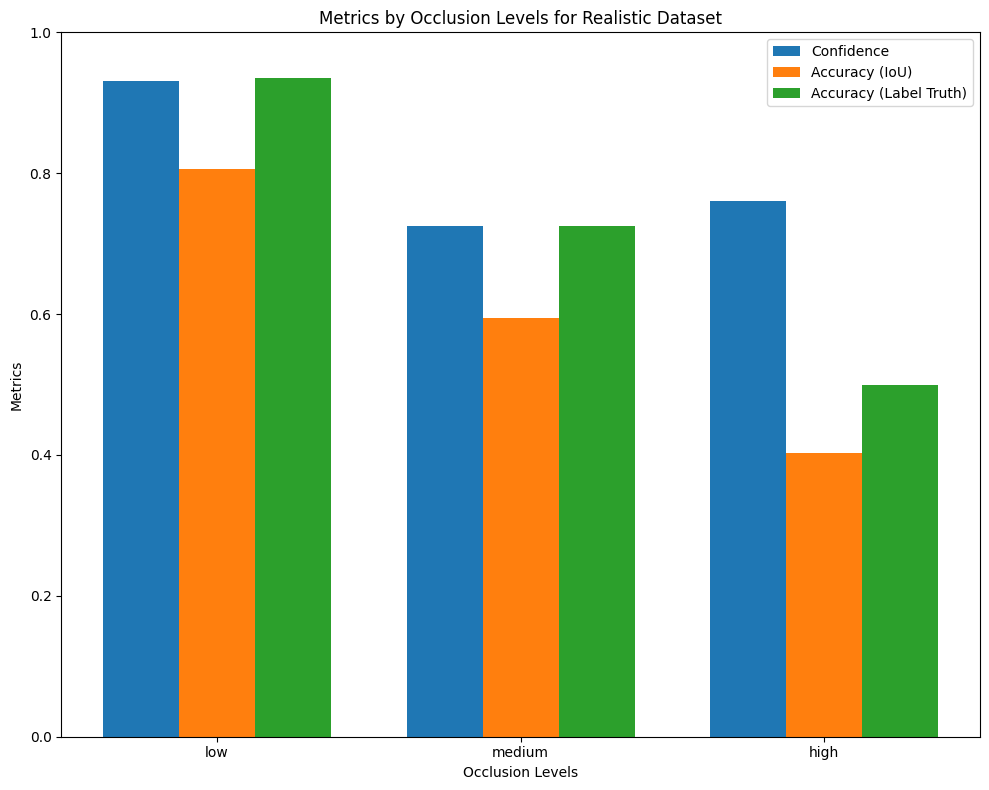

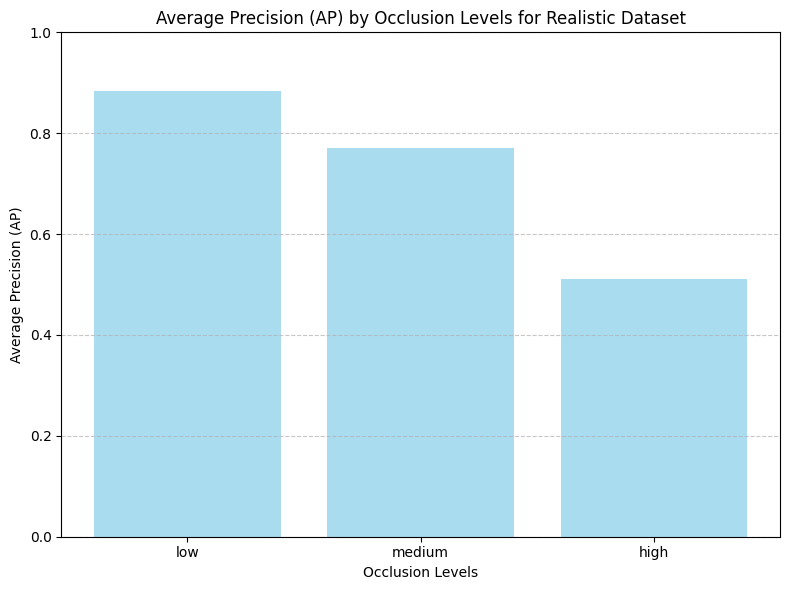

------------------------
Occlusion level: low
------------------------
./unrealistic low small_n02834778_1446.jpg (0.9417887018727988, 'bicycle', 0.999) bicycle
./unrealistic low small_n02834778_11660.jpg (0.7612831852147623, 'bicycle', 0.999) bicycle
./unrealistic low medium_n02834778_12038.jpg (0.8472764006499954, 'bicycle', 0.999) bicycle
./unrealistic low large_n02834778_12736.jpg (0.8715941069375354, 'bicycle', 0.979) bicycle
./unrealistic low large_n02834778_1372.jpg (0.9653921005210169, 'bicycle', 0.999) bicycle
./unrealistic low medium_n02834778_11341.jpg (0.8685803116689401, 'bicycle', 0.999) bicycle
NO VALID BOUNDING BOX
./unrealistic low large_n02834778_1863.jpg (0.8362143287176401, 'bicycle', 0.993) bicycle
./unrealistic low large_n02834778_10394.jpg (0.9320211905018936, 'bicycle', 0.997) bicycle
./unrealistic low small_n02834778_11865.jpg (0.7924623822731262, 'bicycle', 1.0) bicycle
./unrealistic low large_n02834778_10900.jpg (0.7820132625994698, 'bicycle', 0.936) bicycle


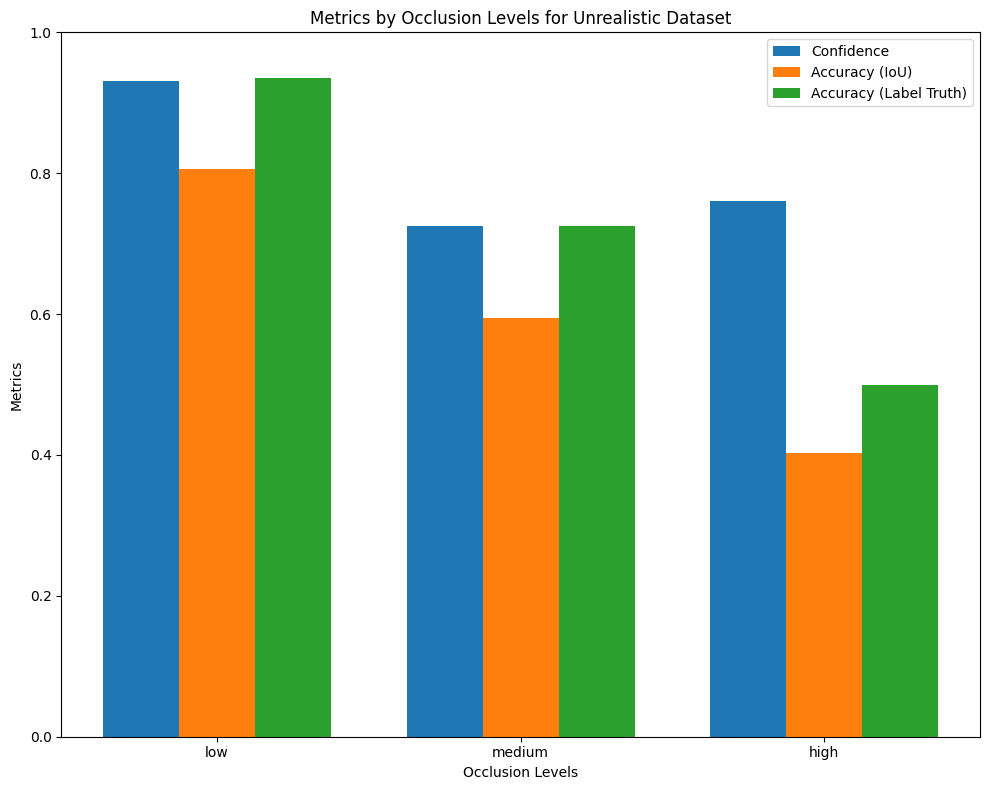

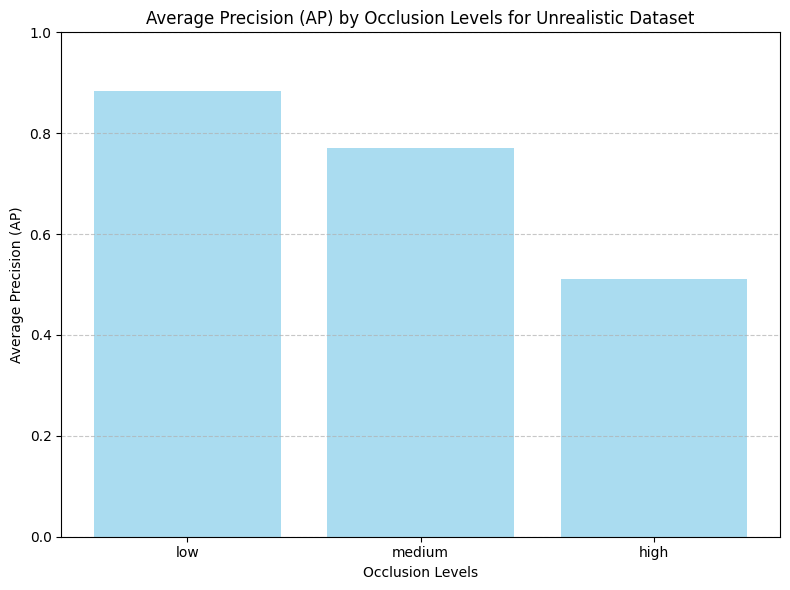

{'./realistic': {'low': 1.0, 'medium': 0.9110937818414776, 'high': 0.49212962962962964}, './unrealistic': {'low': 1.0, 'medium': 0.9999999999999999, 'high': 0.716632639493602}}


In [29]:
'''
Adapted for the Libcom output
'''

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import os
import cv2
# from libcom.utils.process_image import make_image_grid, draw_bbox_on_image
import numpy as np
from sklearn.metrics import average_precision_score

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
 
"""
all_data = {}
for every path: (realistic, unrealistic)
    all_data[path] = {}
    for every level:
        y_true = []
        y_score = []
        for every image:
            get all the ious
            filter all the ious that are less than 0.5
            IF there are none left:
                SKIP THE IMAGE
            
            get the highest score
            if that label is equal to ground truth:
                TRUE POS
                append 1 to y_true
            else: 
                FALSE POS
                append 0 to y_true
            append score to y_score
            
        aps = average_precision_score(y_true, y_score)
        all_data[path][level] = aps
"""
    
all_data = {}

eval_data_file = open("./eval_data.csv", "w")
eval_data_file.write("path_save,level,img_name,score,label,iou,label_truth\n")
    
for path_save in path_saves:
    save_img_path = path_save + '/images'
    save_anno_path = path_save + '/annotations'
    all_data[path_save] = {}
    for level in levels:
        print('------------------------')
        print(f'Occlusion level: {level}')
        print('------------------------')
    
        mean_iou = 0
        mean_confidence = 0
        correct_label_count = 0
        total_predictions = 0
        false_positives = 0
        
        """
        y_true = [] true or false pos
        y_score = [] score of the highest 
        """
        
        # true_pos = 0
        # false_pos = 0
        # false_neg = 0
        y_true = []
        y_score = []
        
        for img_name in os.listdir(os.path.join(save_img_path, level))[:50]:
            
            if img_name[0] == '.':
                continue
        
            img_id = img_name.split('.')[0]
            img_path = os.path.join(save_img_path, level, img_name)
        
            results = process_one_img(processor, model, img_path)
        
            box_truth, occlusion_ratio, occluder_bbox, occluder_path, bg_img, label_truth = read_annotation(os.path.join(save_anno_path, level, img_id + '.json'))
            
            bg_img = Image.open(bg_img) 
            bg_w = bg_img.width 
            bg_h = bg_img.height 
            
            comp_img = Image.open(img_path) 
            comp_w = comp_img.width 
            comp_h = comp_img.height 
            
            box_truth_new = get_updated_bb(box_truth, bg_w, bg_h, comp_w, comp_h)
            
            # print(f"Ground truth: {box_truth}")
        
            greatest_iou = 0
            greatest_iou_label = ''
            total_predictions += 1
            greatest_box_predicted = None
            greatest_confidence = 0
            
            """
            get all the ious
            filter all the ious that are less than 0.5
            IF there are none left:
                SKIP THE IMAGE
            
            get the highest score
            if that label is equal to ground truth:
                TRUE POS
                append 1 to y_true
            else: 
                FALSE POS
                append 0 to y_true
            append score to y_score
            """
            
            iou_label_score = [] # (iou, label, score)
            for i, pred_label in enumerate(results["labels"]):
                label_predicted = model.config.id2label[pred_label.item()]
                # round(score.item(), 3)
                score_i = round(results["scores"][i].item(), 3)
                box_i = results["boxes"][i]
                box_predicted = [round(i, 2) for i in box_i.tolist()]
                iou = bounding_box_intersection_over_union(box_predicted, box_truth_new)
                iou_label_score.append((iou, label_predicted, score_i))
            
            THRESHOLD = 0.5
            filtered_iou_labels = [elem for elem in iou_label_score if elem[0] >= THRESHOLD]
            go_on = True
            if len(filtered_iou_labels) == 0:
                # THERE IS NO VALID BOUNDING BOX
                print("NO VALID BOUNDING BOX")
                go_on = False
            if go_on:
                highest_pair = max(filtered_iou_labels, key=lambda item: item[2]) # the pair with the highest conf score
                highest_label = highest_pair[1]
                print(path_save, level, img_name, highest_pair, label_truth)
                if (label_truth == "motorbike" and highest_label == "motorcycle") or (label_truth == highest_label):
                    # TRUE POSITIVE
                    y_true.append(1)
                else:
                    # FALSE POSITIVE
                    y_true.append(0)
                y_score.append(highest_pair[2])
            
#             """
#             list of labels
#             list of IoUs
            
#             combine iou_list and pred_labels => (iou, label)
#             """
            
            # iou_label = [] # (iou, label)
            # for i, pred_label in enumerate(results["labels"]):
            #     box_i = results["boxes"][i]
            #     score_i = results["scores"][i]
            #     box_predicted = [round(i, 2) for i in box_i.tolist()]
            #     iou = bounding_box_intersection_over_union(box_predicted, box_truth_new)
            #     iou_list.append(iou)
            #     iou_label.append((iou, pred_label, score_i))
                
#             """
#             filter out all ious that are below 0.5
#             """
#             THRESHOLD = 0.5
#             filtered_iou_labels = [elem for elem in iou_label if elem[0] > THRESHOLD]
#             if len(filtered_iou_labels) == 0:
#                 # FALSE NEGATIVE
#                 false_neg += 1
#             highest_pair = max(filtered_iou_labels, key=lambda item: item[0])
#             highest_label = highest_pair[0]
#             if (label_truth == "motorbike" and highest_label == "motorcycle") or (label_truth == highest_label):
#                 # TRUE POSITIVE
#                 true_pos += 1
#             else:
#                 # FALSE POSITIVE
#                 false_pos += 1
                
            # continue
            
            
            #### IGNORE CODE BELOW
        
            # Loops through every bounding box/annotation that the evaluation model produces, 
            for i, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
            
                box_predicted = [round(i, 2) for i in box.tolist()]
                label_predicted = model.config.id2label[label.item()]
                confidence = round(score.item(), 3)
        
                box = [round(i, 2) for i in box.tolist()]
                
        
                # Calculate IoU
                iou = bounding_box_intersection_over_union(box_predicted, box_truth_new)
                
                eval_data_line = path_save+","+level+","+img_name+","+str(confidence)+","+label_predicted+","+str(iou)+","+label_truth+"\n"
                # print(eval_data_line)
                eval_data_file.write(eval_data_line)
                
                if iou >= 0.5:
                    if confidence > greatest_confidence:
                        greatest_confidence = confidence
                        if (label_predicted == "motorcycle" and label_truth == "motorbike") or (label_predicted == label_truth):
                            greatest_iou = iou
                            greatest_iou_label = label_predicted
                            greatest_box_predicted = np.array(box_predicted).astype(int)
                        else: 
                            false_positives += 1
                else:
                    if (label_predicted == "motorcycle" and label_truth == "motorbike") or (label_predicted == label_truth):
                        false_positives += 1
                        

                # precision: (true positives)/(true positives + false positives) 
    
                    
            # Comparing predicted label to truth label  
            if greatest_iou_label == label_truth:
                # Tracking this label's bounding box 
                correct_label_count += 1

    
            mean_iou += greatest_iou
            mean_confidence += greatest_confidence
            
            # cv2.imwrite(f'./predictions/{img_id}.jpg', grid_img)
     
            # # Final statistics
        
        """
        aps = average_precision_score(y_true, y_score)
        all_data[path][level] = aps
        """
        
        aps = average_precision_score(y_true, y_score)
        all_data[path_save][level] = aps
        print(path_save, level, aps)
        continue
        # break
        print("SHOULD NOT PRINT")
        
        print(f"Mean IoU: {mean_iou / total_predictions:.3f}")
        print(f"Total Correct Labels: {correct_label_count}")
        print(f"Avg Correct Labels: {correct_label_count / total_predictions:.3f}\n")
        print(f"False Positives: {false_positives}")
        print(f"AP: {correct_label_count / (correct_label_count + false_positives)}")
        store_metrics(level ,(mean_confidence/ total_predictions), (mean_iou / total_predictions), (correct_label_count / total_predictions), (correct_label_count / (correct_label_count + false_positives)))
        
    # break
    if path_save == './realistic':
        plot_metrics("Realistic")
        plot_average_precision("Realistic")
    elif path_save == './unrealistic':
        plot_metrics("Unrealistic")
        plot_average_precision("Unrealistic")
        
eval_data_file.close()
print(all_data)